In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

In [7]:
#Import helper functions
import numpy as np
import matplotlib.pyplot as plt

# Simulation of non-interacting qubits

In [9]:
#Build an atoms arrangement
from braket.ahs.atom_arrangement import AtomArrangement

# create helper function to generate square lattice
def square_lattice(Nx,Ny,lattice_spacing):
    register = AtomArrangement()
    for ix in range(Nx):
        for iy in range(Ny):
            x = ix * lattice_spacing
            y = iy * lattice_spacing
            register.add((x,y))
            
    return register


**Checking device capabilities for lattices on Aquila**

In [10]:
from braket.aws import AwsDevice 
from pprint import pprint as pp

# defining qpu object
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# capabilities stored as attribute of AwsDevice.
capabilities = qpu.properties.paradigm

# print out lattice
pp(capabilities.lattice.dict())

{'area': {'height': Decimal('0.000076'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


**Create a 3x3 qubits register with spacing larger then blockade radius**

**Visualize qubit register**

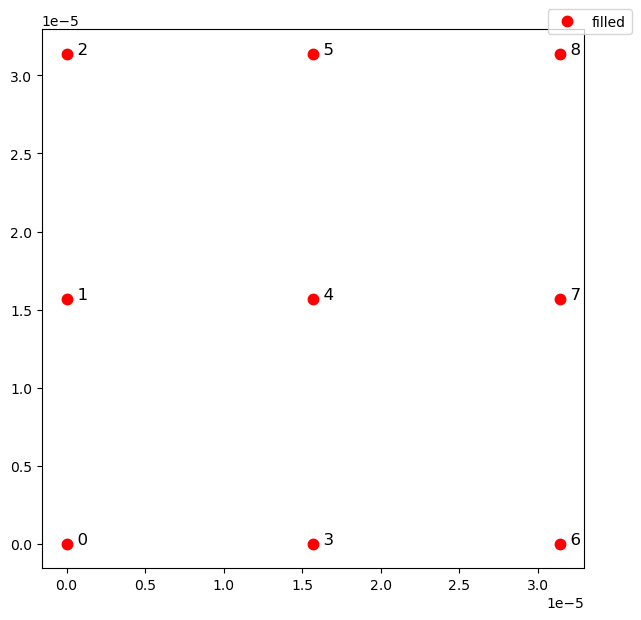

In [11]:
from quera_ahs_utils.plotting import show_register

lattice_spacing = 15.7e-6
far_register = square_lattice(3,3,lattice_spacing)
show_register(far_register)

# Creating driving protocol

**Checking device capabilities for field pulses**

In [12]:
pp(capabilities.rydberg.rydbergGlobal.dict())

{'detuningRange': (Decimal('-125000000.0'), Decimal('125000000.0')),
 'detuningResolution': Decimal('0.2'),
 'detuningSlewRateMax': Decimal('2500000000000000.0'),
 'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
 'phaseResolution': Decimal('5E-7'),
 'rabiFrequencyRange': (Decimal('0.0'), Decimal('15800000.0')),
 'rabiFrequencyResolution': Decimal('400.0'),
 'rabiFrequencySlewRateMax': Decimal('250000000000000.0'),
 'timeDeltaMin': Decimal('5E-8'),
 'timeMax': Decimal('0.000004'),
 'timeMin': Decimal('0.0'),
 'timeResolution': Decimal('1E-9')}


**Create piece-wise linear sweep with constant amplitude and linear detuning**

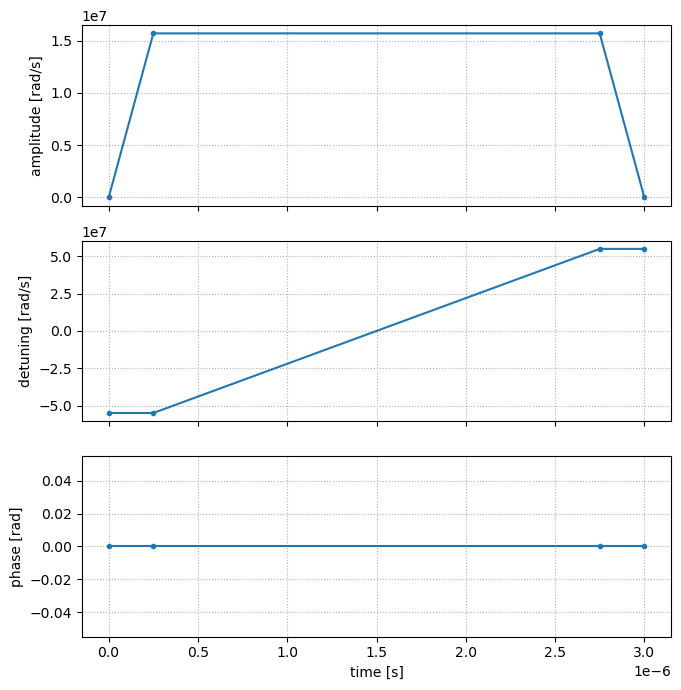

In [13]:
from quera_ahs_utils.plotting import show_global_drive
from quera_ahs_utils.drive import get_drive

time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piece-wise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piece-wise linear
phase_values = [0, 0, 0, 0]  # piece-wise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive)

**Defining simulation program**

In [14]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

# define program
far_ahs_program = AnalogHamiltonianSimulation(
    register=far_register, 
    hamiltonian=drive
)

**Test your program on a local classical simulator (small systems only)**

In [15]:
from braket.devices import LocalSimulator

# running tasks on your computer with a local simulator
qpu_sim = LocalSimulator("braket_ahs")


In [16]:
# function to save results to a file
def save_result(filename,result):

    qpu_results = []
    for measurement in result.measurements: # loop over all shots (measurements)
        qpu_results.append(measurement.post_sequence)

    qpu_results = np.asarray(qpu_results)
    np.savetxt(filename,qpu_results)
    
    
# run program
result = qpu_sim.run(far_ahs_program, shots=1000).result()
save_result("3x3_simulator.txt",result)


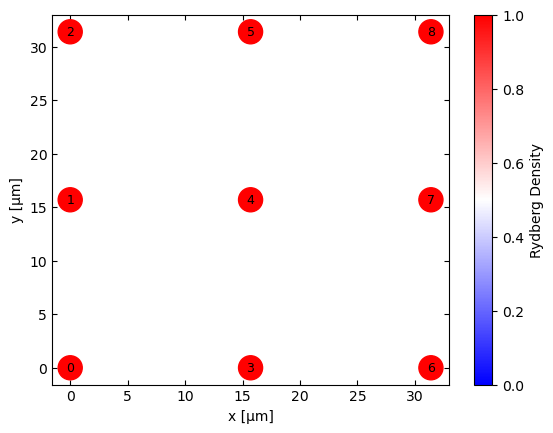

In [17]:
import matplotlib.pyplot as plt
from quera_ahs_utils.plotting import plot_avg_density

# load and analyze results
qpu_results = np.loadtxt("3x3_simulator.txt")

# calculating average rydberg density from shot data
# 0 => rydberg
# 1 => ground state
rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)
plot_avg_density(
    rydberg_density,
    far_register,
    custom_axes = ax
)
plt.show()

**Running same program on Aquila**

In [18]:
from braket.aws import AwsDevice

# object used to submit tasks to quantum hardware. 
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")


**Submit task to Aquila and saving results**

In [19]:
result = qpu.run(far_ahs_program, shots=1000).result()

save_result("3x3_far.txt",result)

KeyboardInterrupt: 

**Look at the average Rydberg density after the sweep**

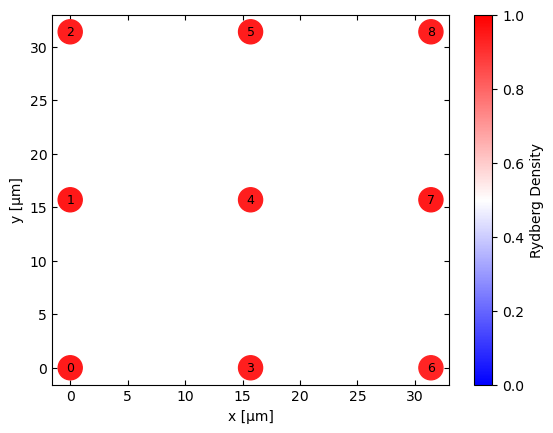

In [12]:

# load and analyze results
qpu_results = np.loadtxt("3x3_far.txt")

rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)
plot_avg_density(
    rydberg_density,
    far_register,
    custom_axes = ax
)
plt.show()


# Effects of Rydberg Blockade

**Decrease the lattice spacing below blockade radius to increase Rydberg interaction**

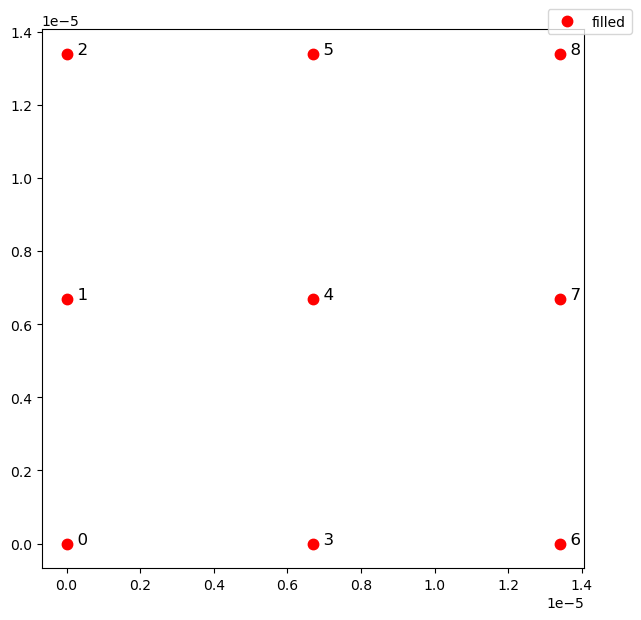

In [20]:
lattice_spacing = 6.7e-6

close_register = square_lattice(3,3,lattice_spacing)
show_register(close_register)

close_ahs_program = AnalogHamiltonianSimulation(
    register=close_register, 
    hamiltonian=drive
)


### Submit task to Aquila

In [21]:
result = qpu.run(close_ahs_program, shots=1000).result()

save_result("3x3_close.txt",result)

KeyboardInterrupt: 

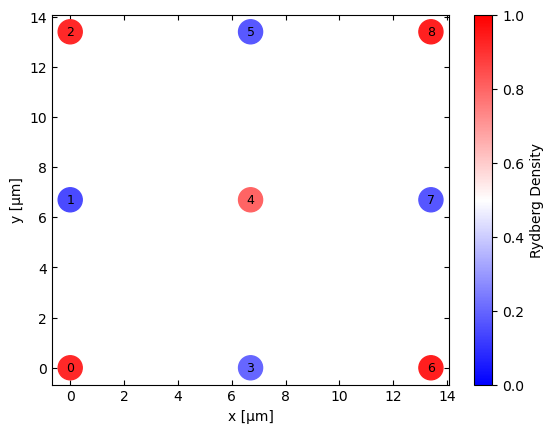

In [14]:
qpu_results = np.loadtxt("3x3_close.txt")

rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)

plot_avg_density(
    rydberg_density,
    close_register,
    custom_axes = ax
)
plt.show()

# Parallel Registers

**Bounding box of single problem**

In [22]:
# get x and y coordinates for all registers
x_coords = np.array([site.coordinate[0] for site in close_register])
y_coords = np.array([site.coordinate[1] for site in close_register])

single_problem_width = x_coords.max() - x_coords.min()
single_problem_height = y_coords.max() - y_coords.min()

**Calculate number of problems to run**

In [23]:

capabilities = qpu.properties.paradigm

# get values from device capabilities
field_of_view_width = float(capabilities.lattice.area.width)
field_of_view_height = float(capabilities.lattice.area.height)
n_site_max = capabilities.lattice.geometry.numberSitesMax

# set distance between batches to fit 3 x 3 problems in total
interproblem_distance = 11.5e-6

# setting up a grid of problems filling the total area

# number of problems to fit in full width of Aquila
n_width = int(field_of_view_width   // (single_problem_width  + interproblem_distance))
# number of problems to fit in full height of Aquila
n_height = int(field_of_view_height // (single_problem_height + interproblem_distance))

print(n_width,n_height)

3 3


**Generate parallel registers and program**

parallel register map:
batch: (0, 0) contains qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8]
batch: (0, 1) contains qubits: [9, 10, 11, 12, 13, 14, 15, 16, 17]
batch: (0, 2) contains qubits: [18, 19, 20, 21, 22, 23, 24, 25, 26]
batch: (1, 0) contains qubits: [27, 28, 29, 30, 31, 32, 33, 34, 35]
batch: (1, 1) contains qubits: [36, 37, 38, 39, 40, 41, 42, 43, 44]
batch: (1, 2) contains qubits: [45, 46, 47, 48, 49, 50, 51, 52, 53]
batch: (2, 0) contains qubits: [54, 55, 56, 57, 58, 59, 60, 61, 62]
batch: (2, 1) contains qubits: [63, 64, 65, 66, 67, 68, 69, 70, 71]
batch: (2, 2) contains qubits: [72, 73, 74, 75, 76, 77, 78, 79, 80]


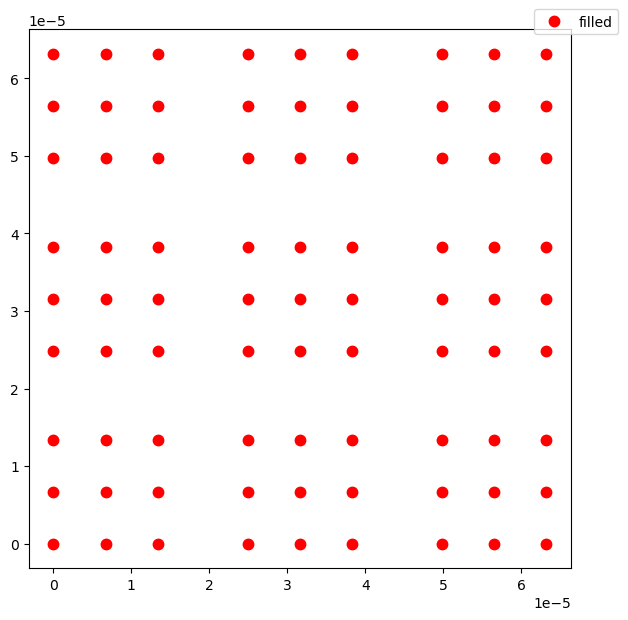

In [24]:
batch_mapping = dict() # keeps track of the qubit index for each parallel register. 
parallel_register = AtomArrangement()

atom_number = 0 # counting number of atoms added

for ix in range(n_width):
    for iy in range(n_height):
        # global shift of each parallel register
        x_shift = ix * (single_problem_width   + interproblem_distance)
        y_shift = iy * (single_problem_height  + interproblem_distance)

        # reached the maximum number of batches possible given n_site_max
        if atom_number + len(close_register) > n_site_max: break 
            
        atoms = []
        for site in close_register:
            new_coordinate = (x_shift + site.coordinate[0], y_shift + site.coordinate[1])
            parallel_register.add(new_coordinate,site.site_type)

            atoms.append(atom_number)

            atom_number += 1 

        batch_mapping[(ix,iy)] = atoms

print("parallel register map:")
for batch,qubits in batch_mapping.items():
    print("batch:",batch,"contains qubits:",qubits)

# generate program
parallel_ahs_program = AnalogHamiltonianSimulation(
    register=parallel_register, 
    hamiltonian=drive
)


parallel_ahs_program = parallel_ahs_program.discretize(qpu)
# show total field of view for the device

show_register(parallel_ahs_program.register,show_atom_index=False)



In [25]:
result = qpu.run(parallel_ahs_program, shots=1000).result()

save_result("3x3_parallel.txt",result)

KeyboardInterrupt: 

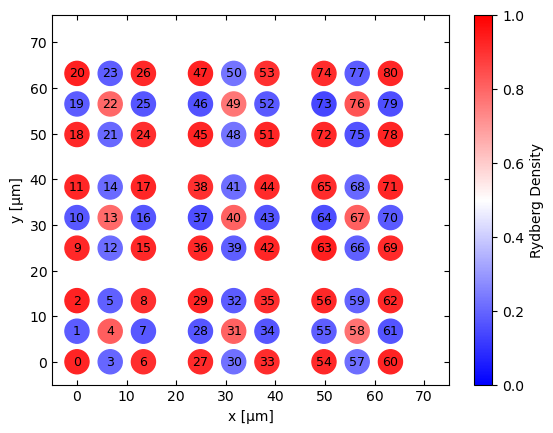

In [18]:
qpu_results = np.loadtxt("3x3_parallel.txt")

rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)

plot_avg_density(
    rydberg_density,
    parallel_ahs_program.register,
    custom_axes = ax
)

# show total field of view for the device
ax.set_ylim((-5,field_of_view_height*1e6))
ax.set_xlim((-5,field_of_view_width*1e6))


plt.show()

# Simulating large system sizes

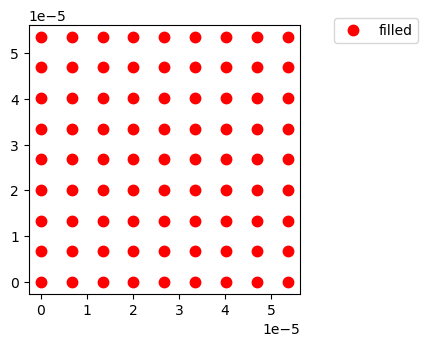

In [19]:
a = 6.7e-6

large_register = square_lattice(9,9,a)

show_register(large_register,show_atom_index=False)

large_ahs_program = AnalogHamiltonianSimulation(
    register=large_register, 
    hamiltonian=drive
)


In [ ]:
result = qpu.run(large_ahs_program, shots=1000).result()

save_result("9x9.txt",result)

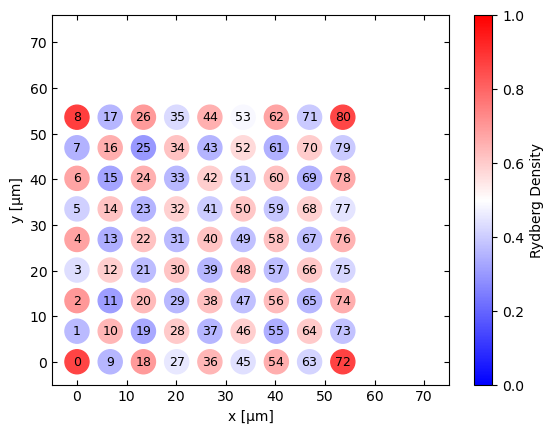

In [20]:
qpu_results = np.loadtxt("9x9.txt")

rydberg_density = np.mean(1-qpu_results,axis=0)

f,ax = plt.subplots(1,1)

plot_avg_density(
    rydberg_density,
    large_register,
    custom_axes = ax
)

ax.set_ylim((-5,field_of_view_height*1e6))
ax.set_xlim((-5,field_of_view_width*1e6))

plt.show()